# Library Setup

In [1]:
# Install packages
install.packages(c("VGAM", "ggplot2", "dplyr", "tidyr", "caret", "performance", "ggpubr", "corrplot", "Metrics", "DescTools"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘Deriv’, ‘microbenchmark’, ‘diagram’, ‘lava’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘prodlim’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘car’, ‘rootSolve’, ‘lmom’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘bayestestR’, ‘insight’, ‘datawizard’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘mvtnorm’, ‘expm’, ‘Exact’, ‘gld’




In [2]:
# Load libraries
library(VGAM)
library(ggplot2)
library(dplyr)
library(tidyr)
library(caret)
library(performance)
library(ggpubr)
library(corrplot)
library(Metrics)
library(DescTools)

Loading required package: stats4

Loading required package: splines


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:VGAM’:

    predictors


corrplot 0.95 loaded


Attaching package: ‘Metrics’


The following objects are masked from ‘package:performance’:

    mae, mse, rmse


The following objects are masked from ‘package:caret’:

    precision, recall



Attaching package: ‘DescTools’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:VGAM’:

    Rank




# Load Data

In [3]:
# Load the dataset
data("pneumo", package = "VGAM")

# View the dataset
pneumo

,exposure.time,normal,mild,severe
,<dbl>,<dbl>,<dbl>,<dbl>
1,5.8,98,0,0
2,15.0,51,2,1
3,21.5,34,6,3
4,27.5,35,5,8
5,33.5,32,10,9
6,39.5,23,7,8
7,46.0,12,6,10
8,51.5,4,2,5


In [4]:
# Function to interpolate between two rows
interpolate_rows <- function(row1, row2) {
  weight <- runif(1) # Random weight between 0 and 1
  interpolated_row <- row1 * (1 - weight) + row2 * weight
  return(as.data.frame(t(interpolated_row)))
}

In [5]:
# Create new samples
new_samples <- do.call(rbind, lapply(1:(nrow(pneumo) - 1), function(i) {
  interpolate_rows(as.numeric(pneumo[i, ]), as.numeric(pneumo[i + 1, ]))
}))

# Rename columns to match the original dataframe
colnames(new_samples) <- colnames(pneumo)

# Combine the original and new samples
pneumo_doubled <- rbind(pneumo, new_samples)

In [6]:
# Round and format values
pneumo_doubled$exposure.time <- round(pneumo_doubled$exposure.time, 1)
pneumo_doubled$normal <- as.integer(round(pneumo_doubled$normal))
pneumo_doubled$mild <- as.integer(round(pneumo_doubled$mild))
pneumo_doubled$severe <- as.integer(round(pneumo_doubled$severe))

# Reindex and order by exposure.time
pneumo_doubled <- pneumo_doubled[order(pneumo_doubled$exposure.time), ]
row.names(pneumo_doubled) <- seq_len(nrow(pneumo_doubled))

# View the resulting dataset
print("Doubled and Formatted Dataset:")
pneumo_doubled

[1] "Doubled and Formatted Dataset:"


,exposure.time,normal,mild,severe
,<dbl>,<int>,<int>,<int>
1,5.8,98,0,0
2,8.9,82,1,0
3,15.0,51,2,1
4,18.8,41,4,2
5,21.5,34,6,3
6,24.9,35,5,6
7,27.5,35,5,8
8,33.3,32,10,9
9,33.5,32,10,9


In [7]:
# Reshape data to long format for visualization
pneumo_long <- pneumo_doubled %>%
  pivot_longer(
    cols = c(normal, mild, severe),
    names_to = "status",
    values_to = "count"
  )

print("Long format of 'pneumo' dataset:")
head(pneumo_long)

[1] "Long format of 'pneumo' dataset:"


exposure.time,status,count
<dbl>,<chr>,<int>
5.8,normal,98
5.8,mild,0
5.8,severe,0
8.9,normal,82
8.9,mild,1
8.9,severe,0


# Explore Data

In [8]:
# Check the structure of the dataset
pneumo <- pneumo_doubled
str(pneumo)
cat("\n")

# Summary statistics
summary(pneumo)

'data.frame':	15 obs. of  4 variables:
 $ exposure.time: num  5.8 8.9 15 18.8 21.5 24.9 27.5 33.3 33.5 36.3 ...
 $ normal       : int  98 82 51 41 34 35 35 32 32 28 ...
 $ mild         : int  0 1 2 4 6 5 5 10 10 9 ...
 $ severe       : int  0 0 1 2 3 6 8 9 9 9 ...



 exposure.time       normal          mild            severe      
 Min.   : 5.80   Min.   : 4.0   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:20.15   1st Qu.:19.0   1st Qu.: 2.500   1st Qu.: 2.500  
 Median :33.30   Median :32.0   Median : 5.000   Median : 6.000  
 Mean   :30.44   Mean   :35.2   Mean   : 5.067   Mean   : 5.667  
 3rd Qu.:41.80   3rd Qu.:38.0   3rd Qu.: 6.500   3rd Qu.: 9.000  
 Max.   :51.50   Max.   :98.0   Max.   :10.000   Max.   :10.000  

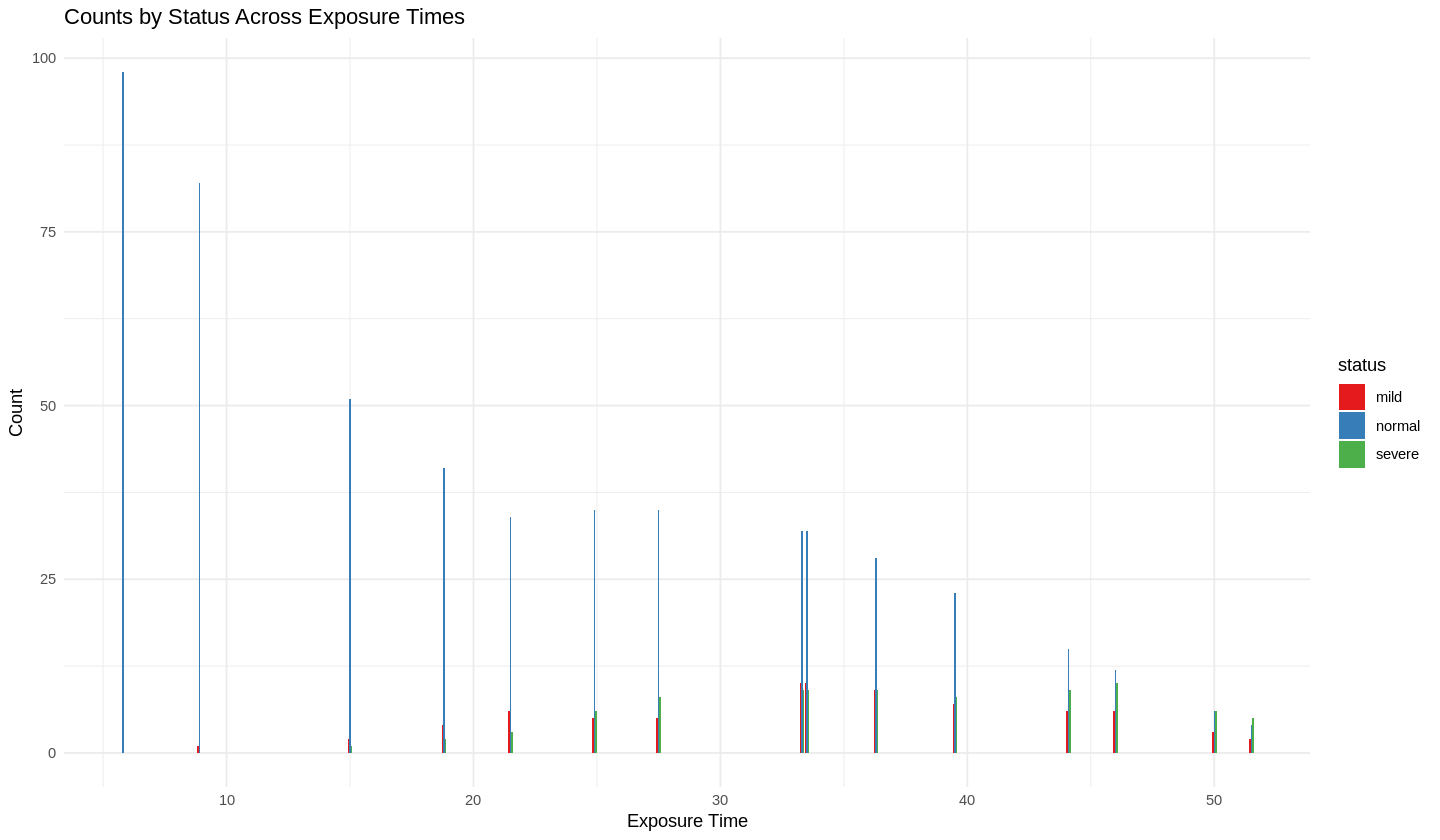

In [9]:
# Bar plot of counts by status across exposure times
options(repr.plot.width = 12, repr.plot.height = 7)
ggplot(pneumo_long, aes(x = exposure.time, y = count, fill = status)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = "Counts by Status Across Exposure Times",
    x = "Exposure Time",
    y = "Count"
  ) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set1")

In [10]:
# Calculate proportions
pneumo_prop <- pneumo_long %>%
  group_by(exposure.time) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup()

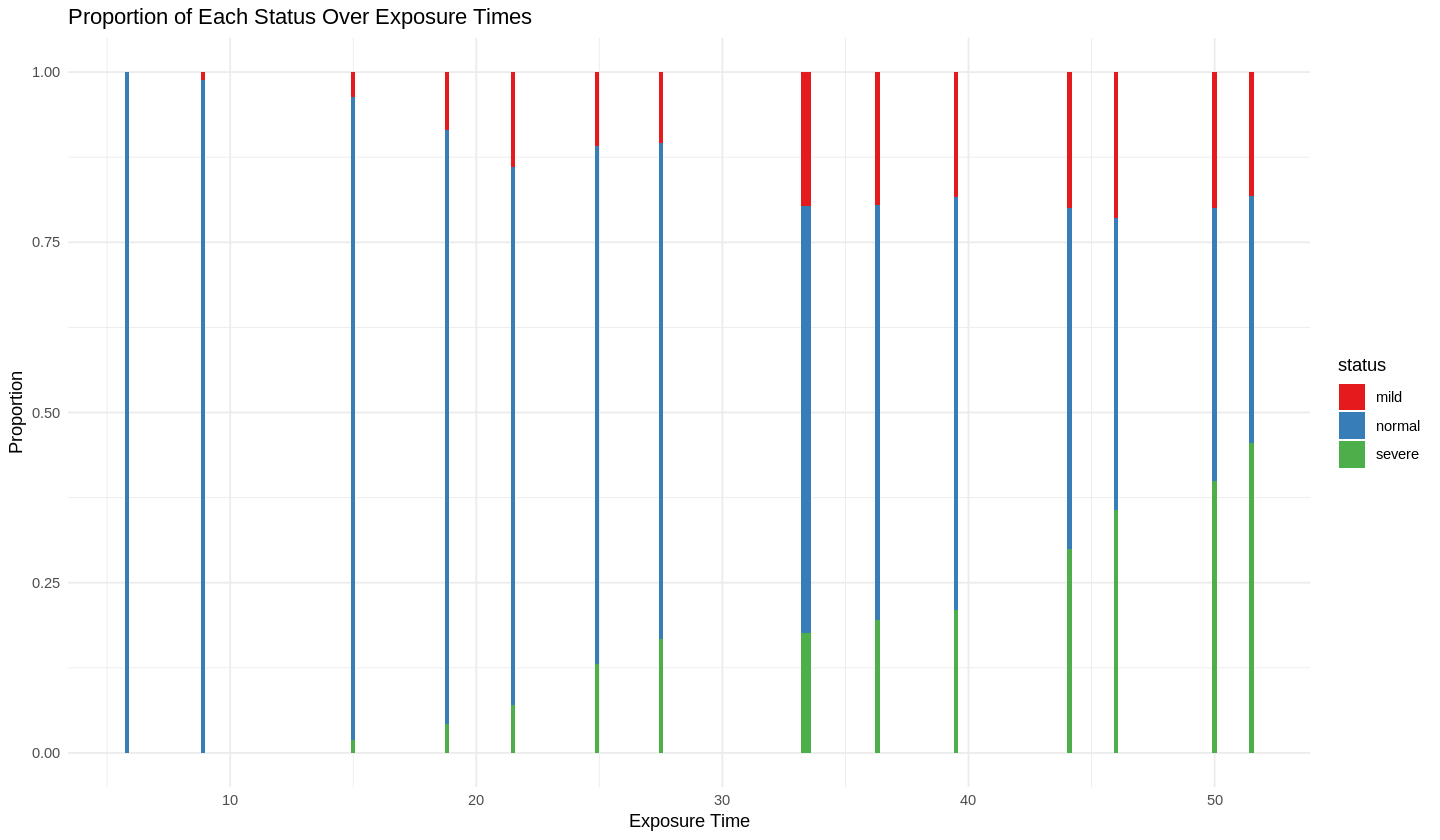

In [11]:
# Stacked bar plot of proportions
options(repr.plot.width = 12, repr.plot.height = 7)
ggplot(pneumo_prop, aes(x = exposure.time, y = prop, fill = status)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Proportion of Each Status Over Exposure Times",
    x = "Exposure Time",
    y = "Proportion"
  ) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set1")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


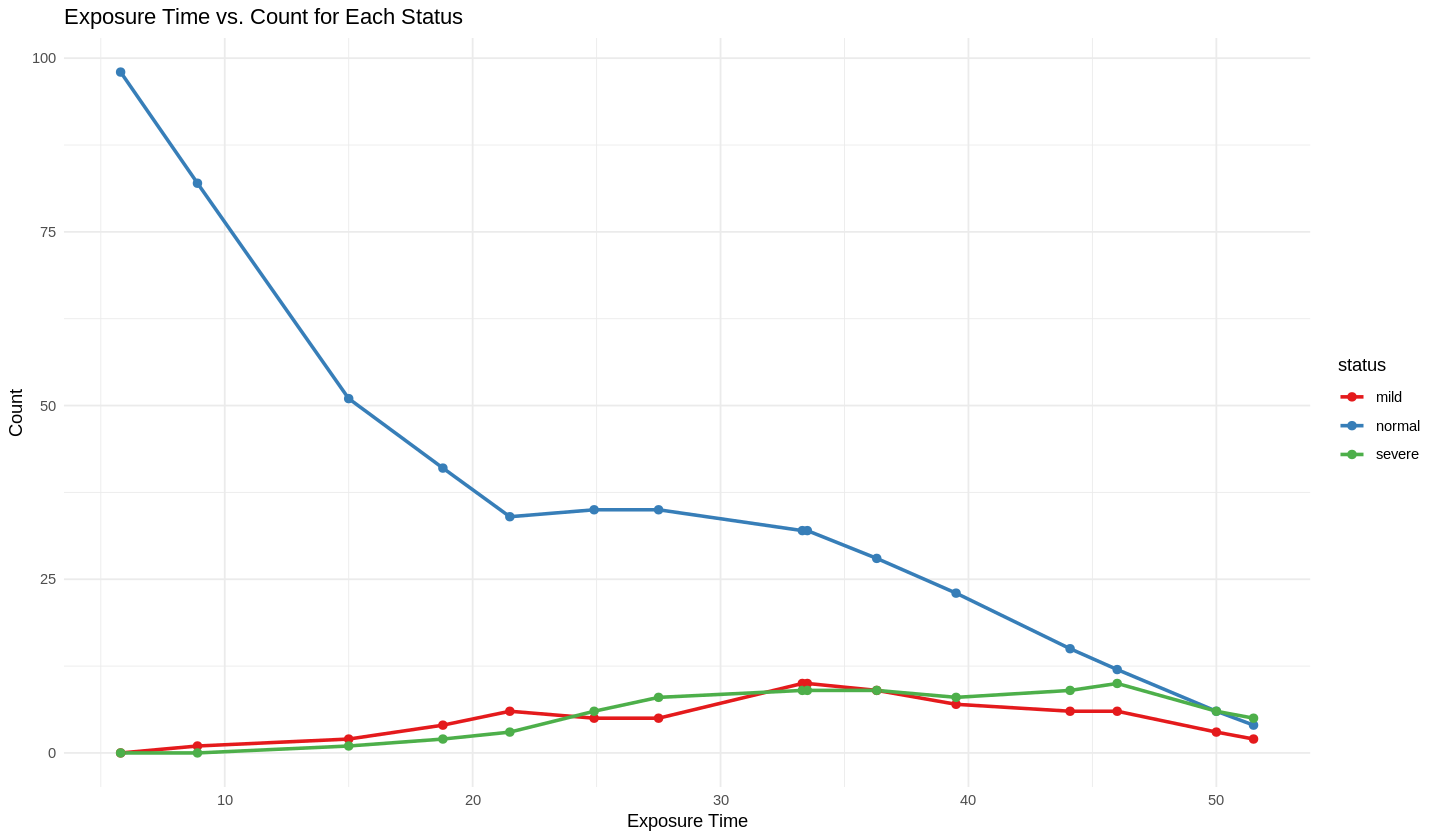

In [12]:
# Line plot with points for each status
options(repr.plot.width = 12, repr.plot.height = 7)
ggplot(pneumo_long, aes(x = exposure.time, y = count, color = status)) +
  geom_line(aes(group = status), size = 1) +
  geom_point(size = 2) +
  labs(
    title = "Exposure Time vs. Count for Each Status",
    x = "Exposure Time",
    y = "Count"
  ) +
  theme_minimal() +
  scale_color_brewer(palette = "Set1")

[1] "Correlation Matrix:"


,exposure.time,normal,mild,severe
exposure.time,1.0000000,-0.9277725,0.4033023,0.7617172
normal,-0.9277725,1.0000000,-0.4687811,-0.7225751
mild,0.4033023,-0.4687811,1.0000000,0.8017234
severe,0.7617172,-0.7225751,0.8017234,1.0000000


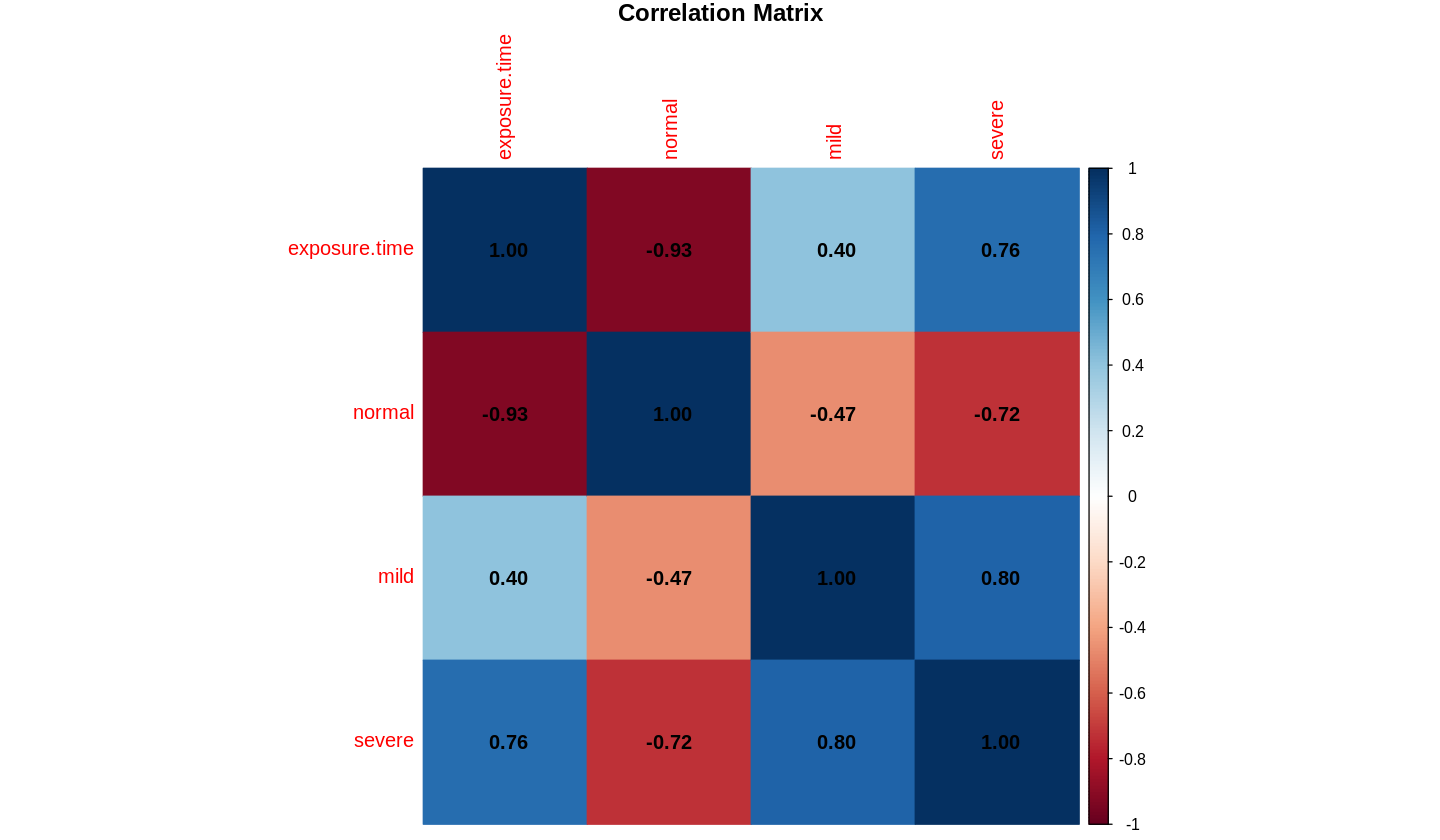

In [13]:
# Correlation matrix for numerical variables
cor_matrix <- cor(pneumo[, c("exposure.time", "normal", "mild", "severe")])
print("Correlation Matrix:")
cor_matrix
cat("\n")

# Visualize correlation matrix
options(repr.plot.width = 12, repr.plot.height = 7)
corrplot(cor_matrix, method = "color", addCoef.col = "black",
         tl.cex = 1, number.cex = 1, title = "Correlation Matrix",
         mar = c(0,0,1,0))

# Prepare Data

In [14]:
# Transform exposure time
pneumo <- pneumo %>%
  mutate(let = log(exposure.time))

# Check the transformation
print("Transformed 'let' variable:")
pneumo$let

[1] "Transformed 'let' variable:"


[1] 1.757858 2.186051 2.708050 2.933857 3.068053 3.214868 3.314186 3.505557
 [9] 3.511545 3.591818 3.676301 3.786460 3.828641 3.912023 3.941582

# Explanatory Modeling

In [15]:
# Fit VGLM proportional odds model
vglm_model_full <- vglm(
  cbind(normal, mild, severe) ~ let,
  family = cumulative(parallel = TRUE),
  data = pneumo
)

# Summary of the VGLM model
print("Summary of VGLM Model on Full Dataset:")
summary(vglm_model_full)

[1] "Summary of VGLM Model on Full Dataset:"


Call:
vglm(formula = cbind(normal, mild, severe) ~ let, family = cumulative(parallel = TRUE), 
    data = pneumo)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1   9.5296     0.9521  10.009   <2e-16 ***
(Intercept):2  10.4518     0.9671  10.808   <2e-16 ***
let            -2.5541     0.2740  -9.321   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Names of linear predictors: logitlink(P[Y<=1]), logitlink(P[Y<=2])

Residual deviance: 7.6773 on 27 degrees of freedom

Log-likelihood: -47.7804 on 27 degrees of freedom

Number of Fisher scoring iterations: 4 

'(Intercept):1'


Exponentiated coefficients:
       let 
0.07776007 

In [16]:
# Fit VGAM proportional odds model
vgam_model_full <- vgam(
  cbind(normal, mild, severe) ~ s(let),
  family = cumulative(parallel = TRUE, reverse = FALSE),
  data = pneumo,
  trace = TRUE
)

# Summary of the VGAM model
print("Summary of VGAM Model on Full Dataset:")
summary(vgam_model_full)

VGAM  s.vam  loop  1 :  deviance = 5.1009256
VGAM  s.vam  loop  2 :  deviance = 4.8158619
VGAM  s.vam  loop  3 :  deviance = 4.7953726
VGAM  s.vam  loop  4 :  deviance = 4.7947987
VGAM  s.vam  loop  5 :  deviance = 4.7947966
VGAM  s.vam  loop  6 :  deviance = 4.7947966
[1] "Summary of VGAM Model on Full Dataset:"



Call:
vgam(formula = cbind(normal, mild, severe) ~ s(let), family = cumulative(parallel = TRUE, 
    reverse = FALSE), data = pneumo, trace = TRUE)

Names of additive predictors: logitlink(P[Y<=1]), logitlink(P[Y<=2])

Dispersion Parameter for cumulative family:   1

Residual deviance:  4.7948 on 24.257 degrees of freedom

Log-likelihood: -46.33917 on 24.257 degrees of freedom

Number of Fisher scoring iterations:  6 

DF for Terms and Approximate Chi-squares for Nonparametric Effects

              Df Npar Df Npar Chisq  P(Chi)
(Intercept):1  1                           
(Intercept):2  1                           
s(let)         1     2.7    2.47149 0.43249

# Goodness of Fit

In [17]:
# Log-likelihood for VGLM
vglm_gof <- logLik(vglm_model_full)
print(paste("VGLM Log-Likelihood:", round(vglm_gof, 2)))

# Log-likelihood for VGAM
vgam_gof <- logLik(vgam_model_full)
print(paste("VGAM Log-Likelihood:", round(vgam_gof, 2)))

[1] "VGLM Log-Likelihood: -47.78"
[1] "VGAM Log-Likelihood: -46.34"


In [18]:
# AIC for VGLM
vglm_aic <- AIC(vglm_model_full)
print(paste("VGLM AIC:", round(vglm_aic, 2)))

# AIC for VGAM
vgam_aic <- AIC(vgam_model_full)
print(paste("VGAM AIC:", round(vgam_aic, 2)))

[1] "VGLM AIC: 101.56"
[1] "VGAM AIC: 104.16"


In [19]:
# BIC for VGLM
vglm_bic <- BIC(vglm_model_full)
print(paste("VGLM BIC:", round(vglm_bic, 2)))

# BIC for VGAM
vgam_bic <- BIC(vgam_model_full)
print(paste("VGAM BIC:", round(vgam_bic, 2)))

[1] "VGLM BIC: 103.69"
[1] "VGAM BIC: 108.23"


# Residual Diagnostics

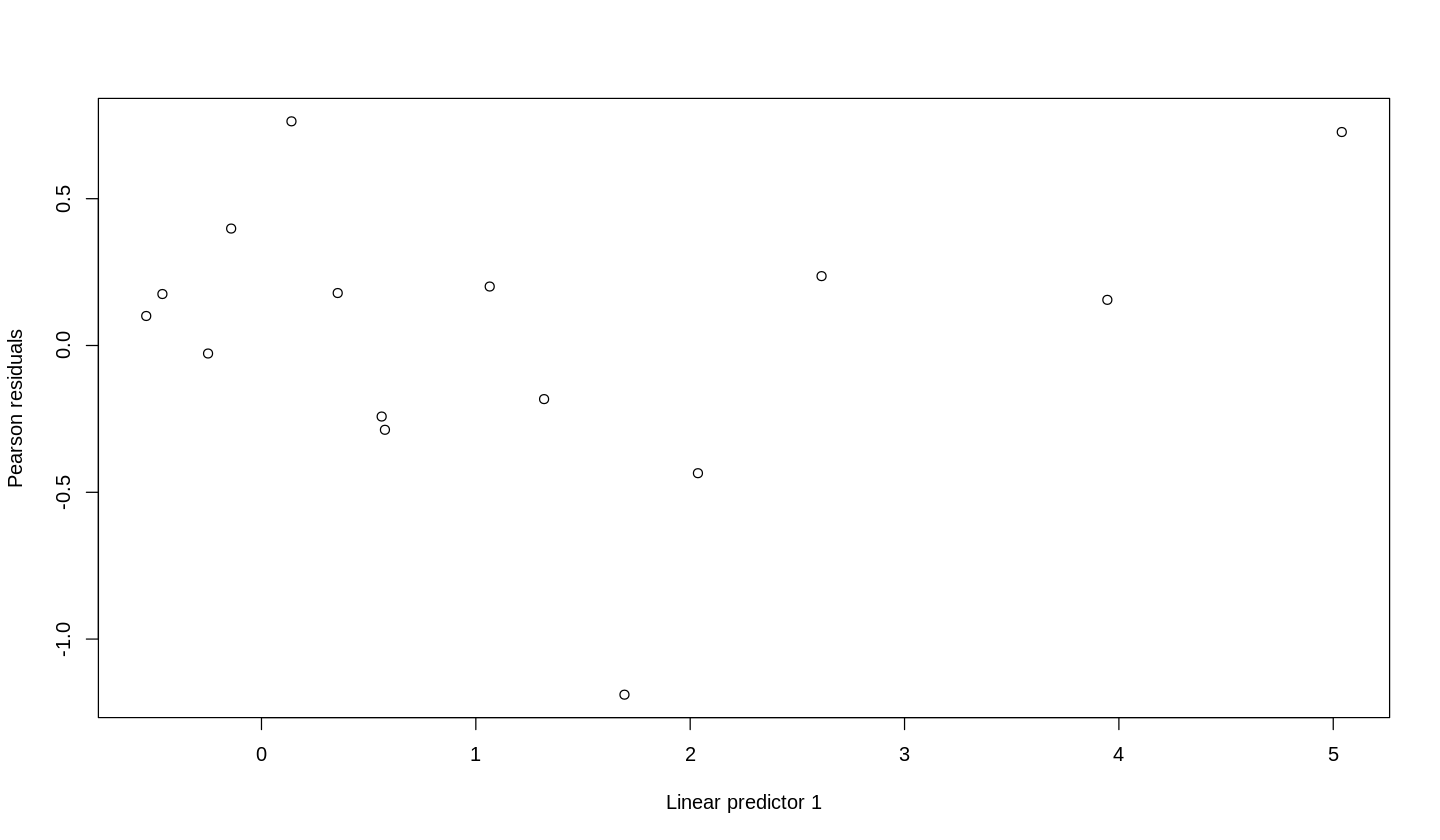

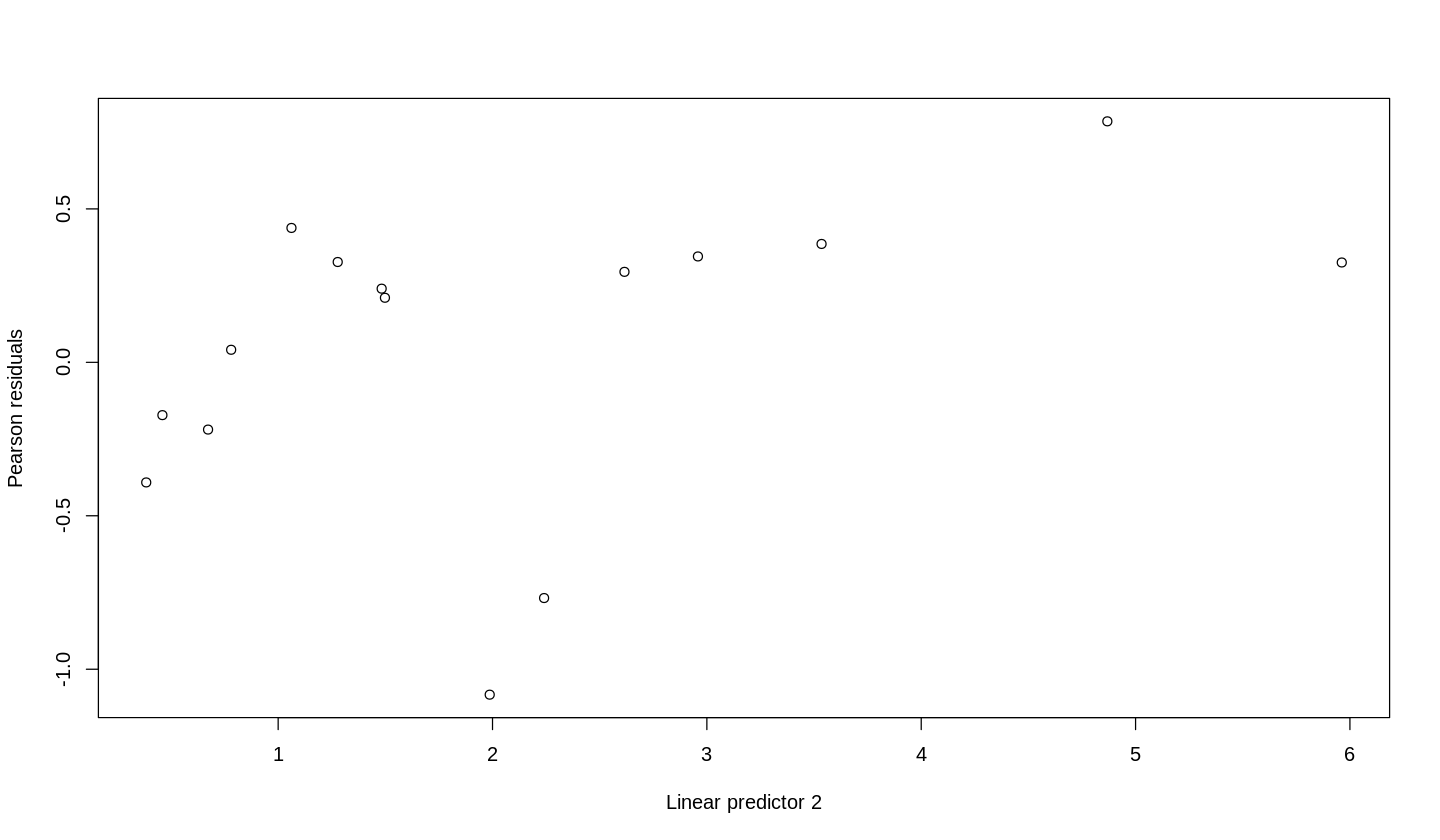

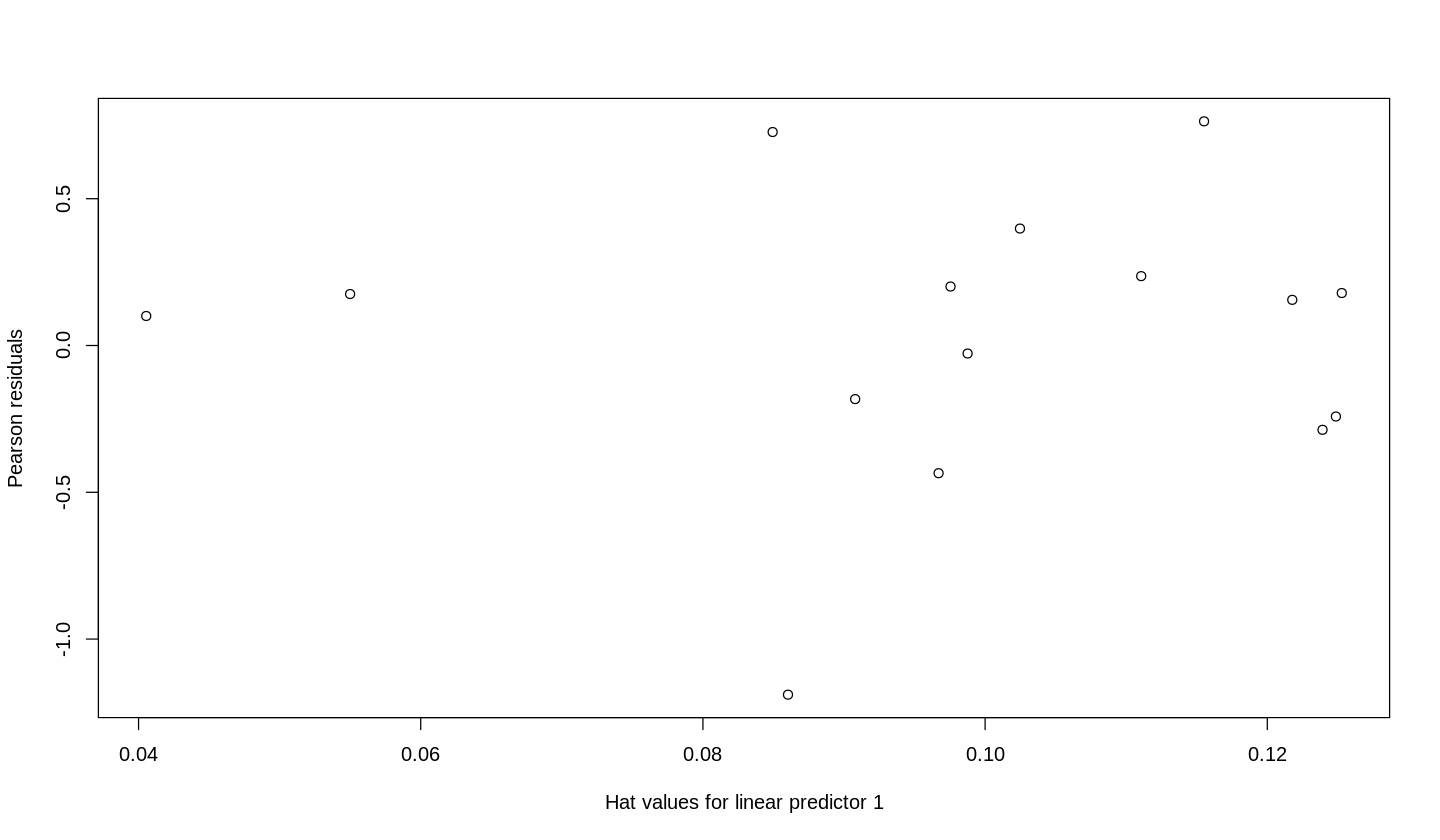

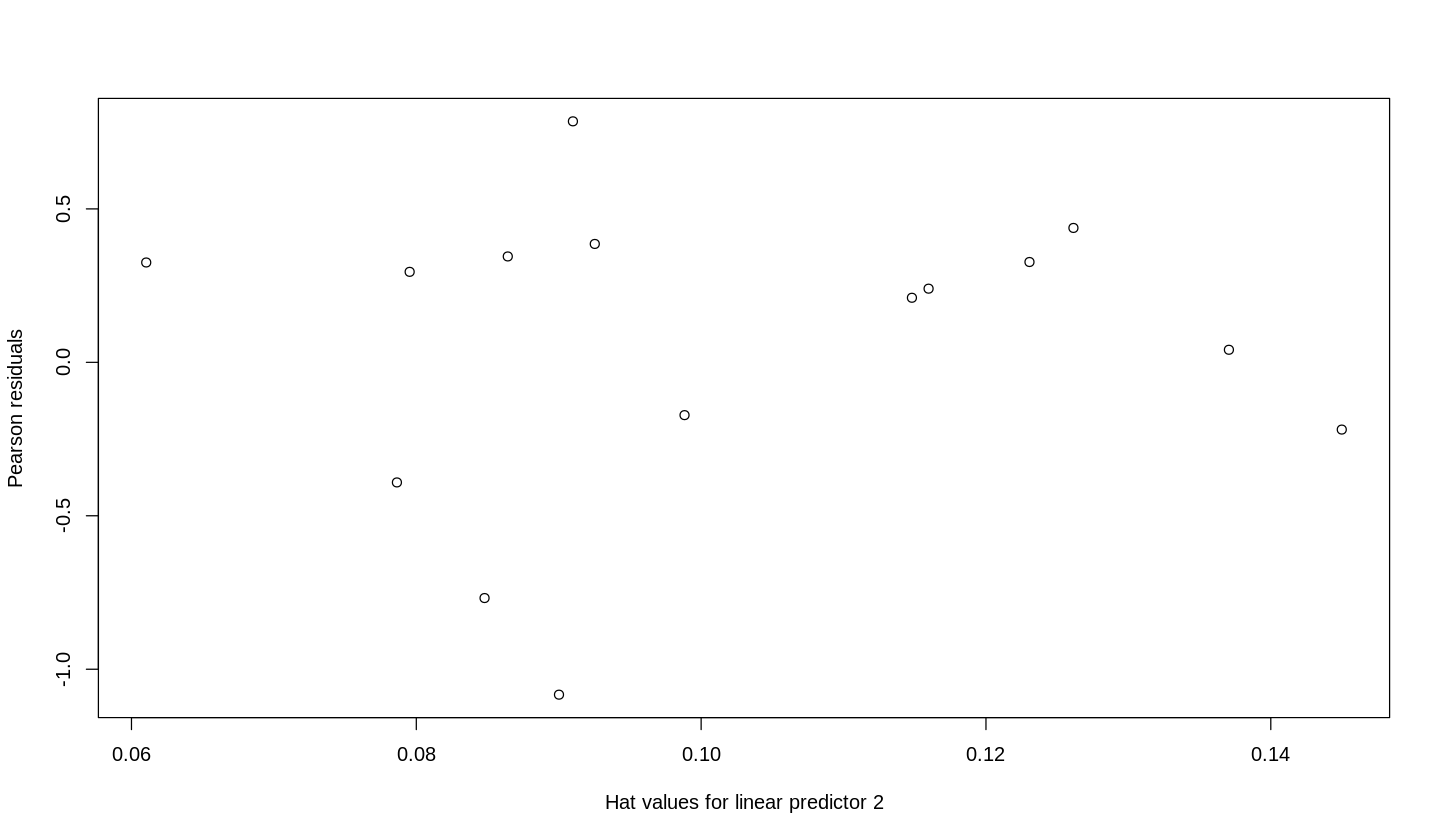

In [20]:
# Residuals for VGLM
plotvglm(vglm_model_full)

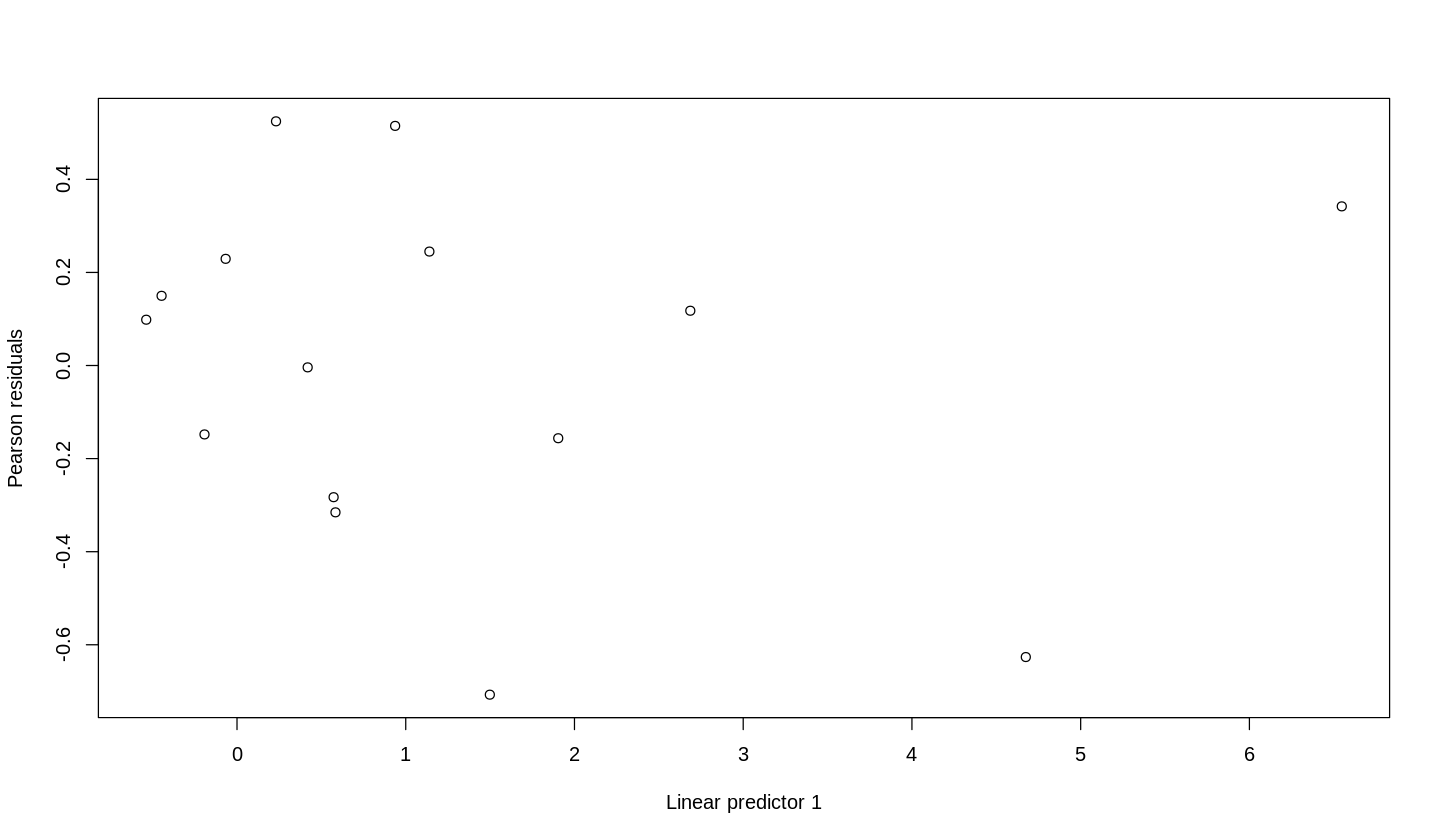

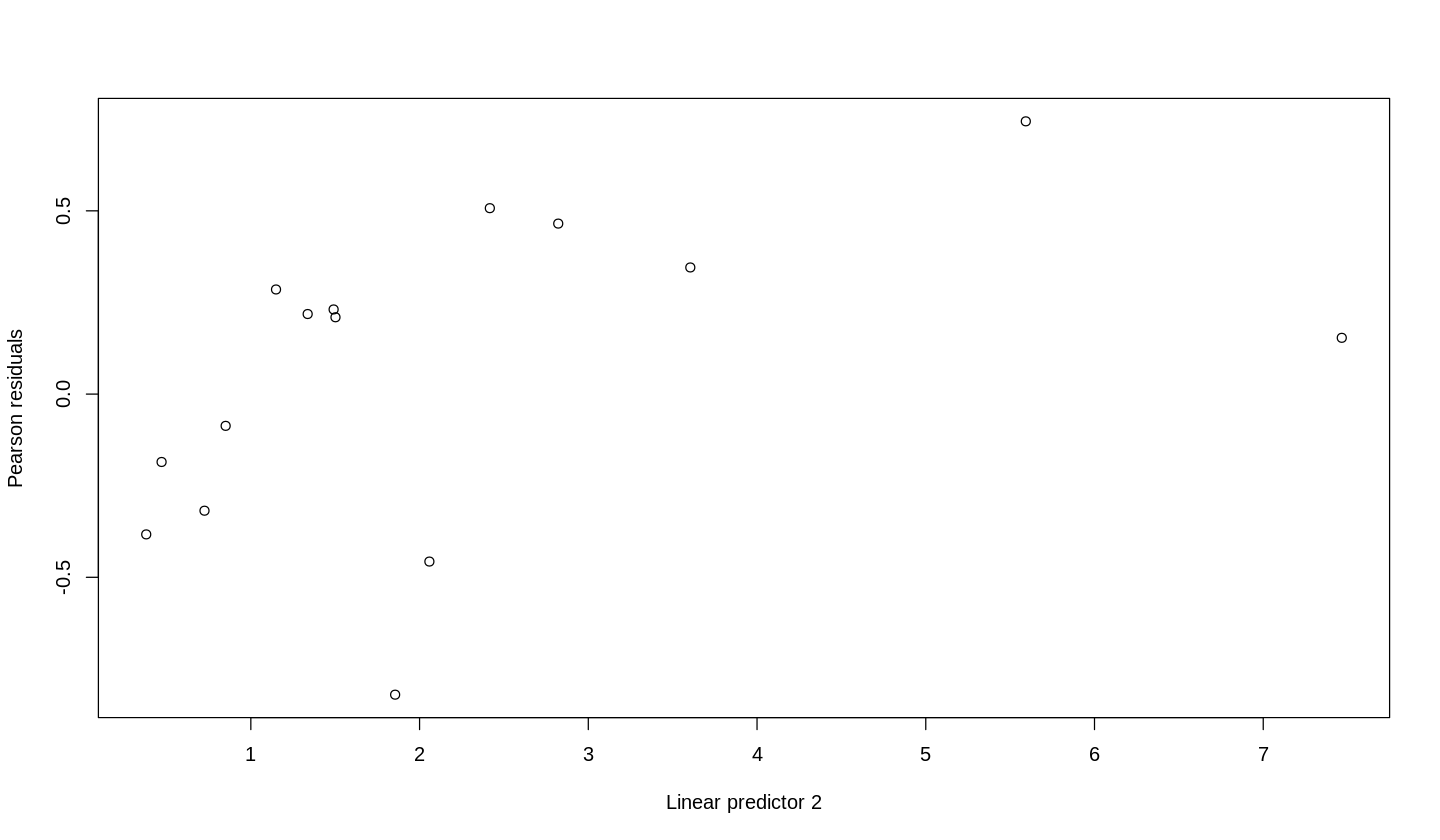

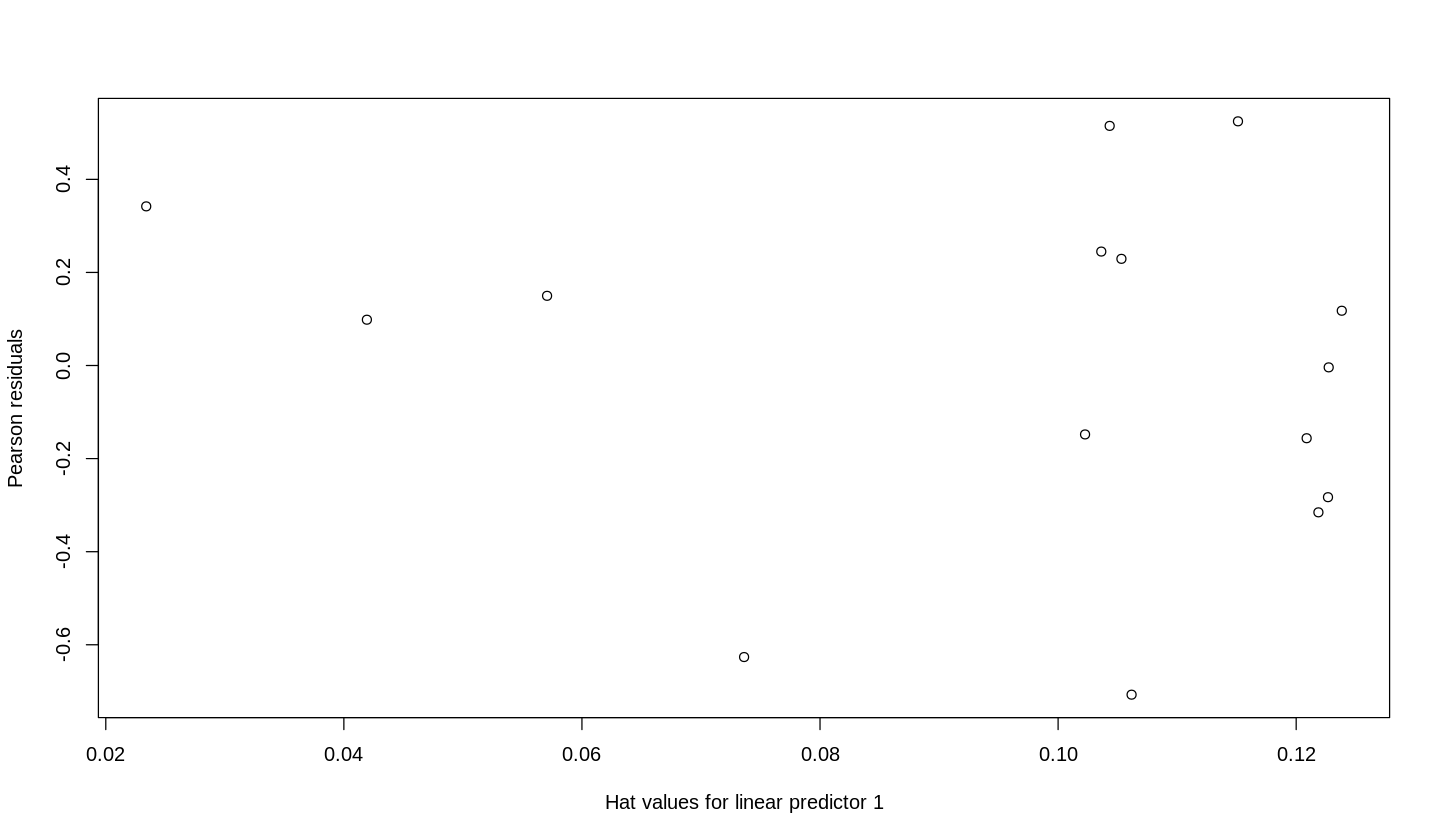

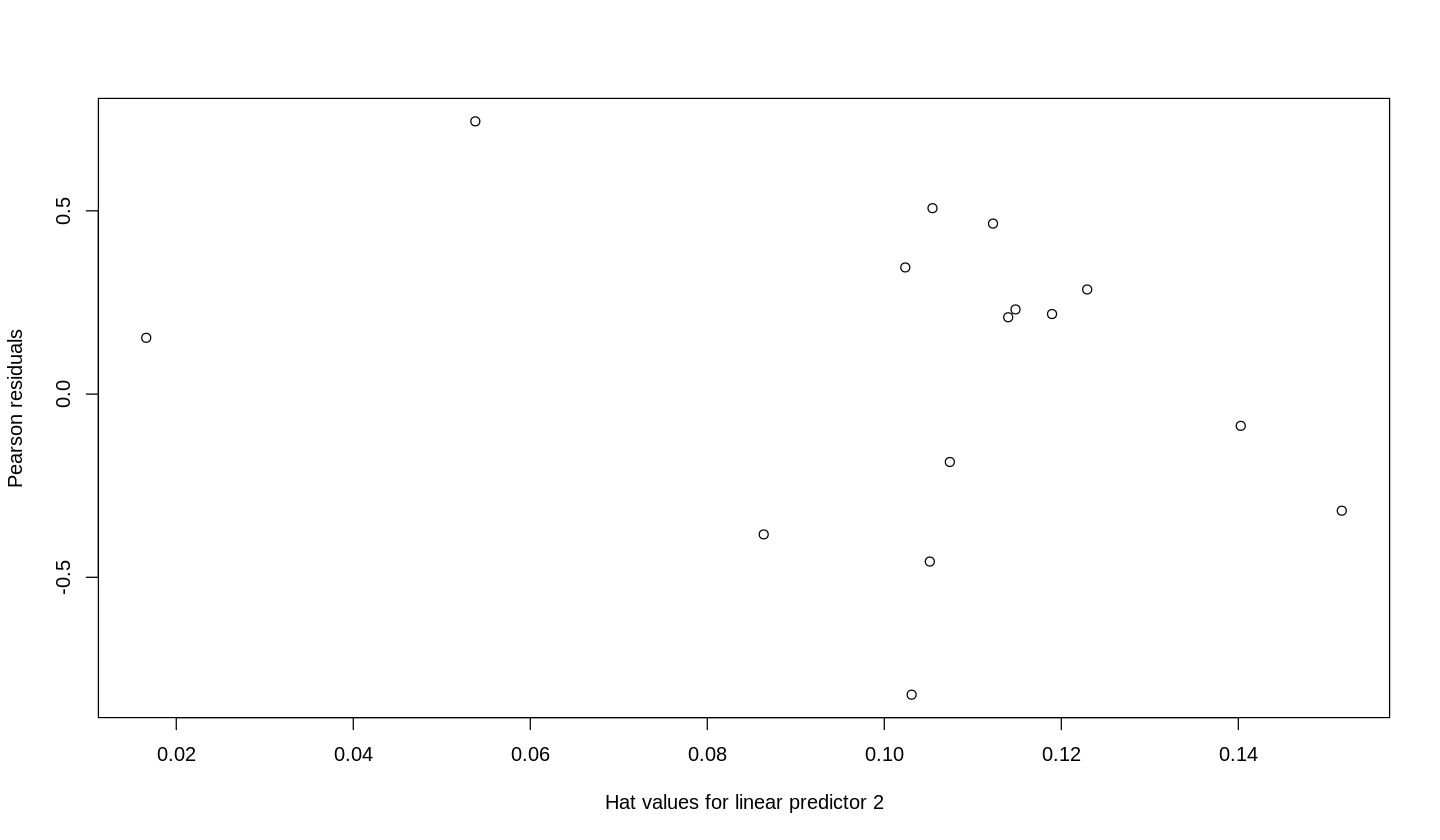

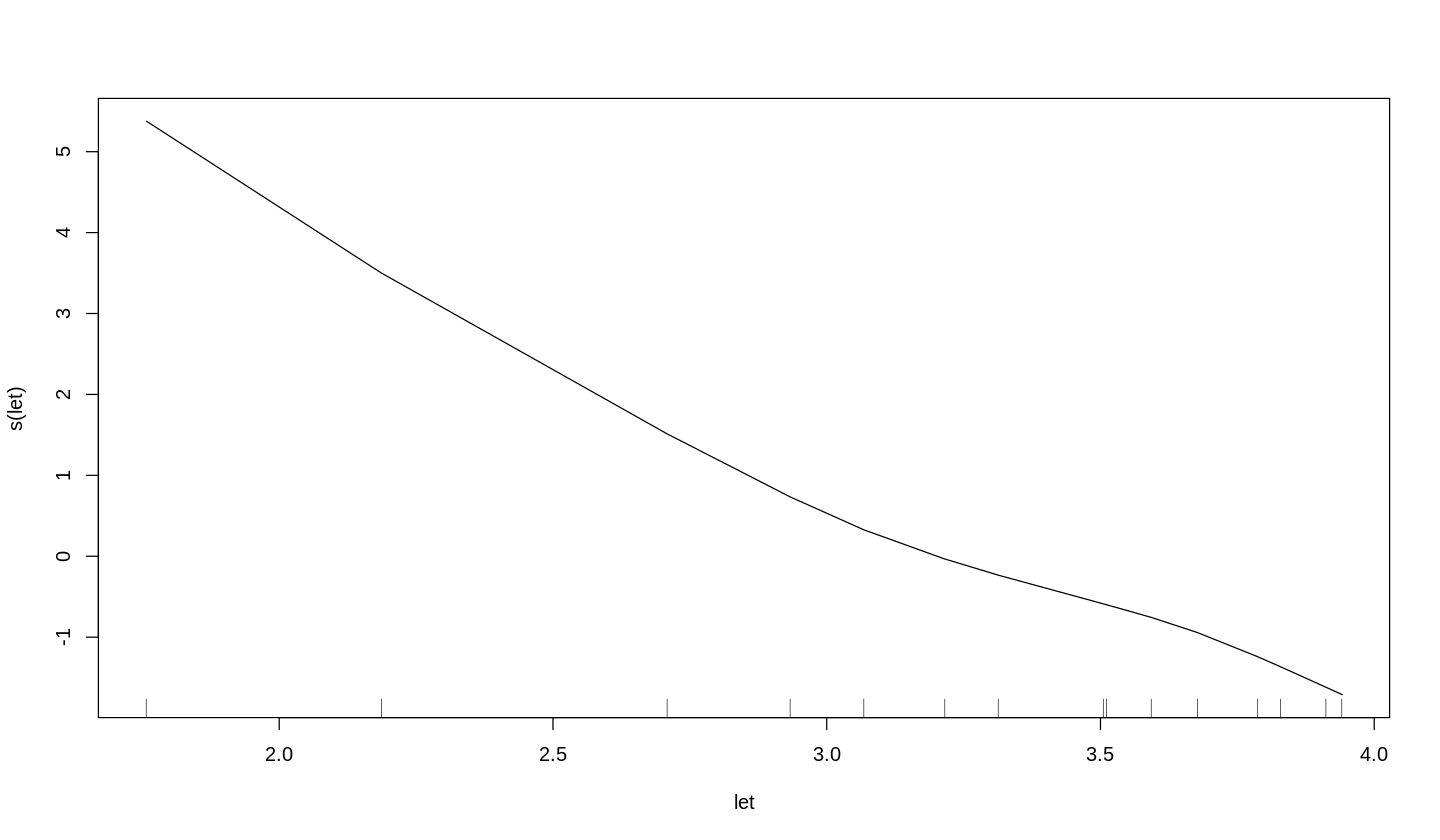

In [21]:
# Residuals for VGAM
plotvglm(vgam_model_full)
plotvgam(vgam_model_full)